# Chapter 05: Multiple Linear Regression

In [3]:
# import of some library

import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy as sp
import seaborn as sns

# Configuração para o notebook e plotagem de imagens
from IPython.display import Latex
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
def jupyter_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
   # display(HTML('<style>.container { width:100% !important; }</style>'))
    sns.set()

jupyter_settings()

from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm
from sklearn import datasets
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In the last chapter, we discussed **simple linear regression (SLR)** using one variable to explain a target variable. In this chapter, we will extend this idea to **multiple linear regression (MLR)** using more than one variable to explain a target variable.

Two essential points in MLR are:

- The multicollinearity
- The bias-variance tradeoff

This two points are essential to understand to get a better performance in MLR. We will see these points in the next sections.

## 5.1 -  Definition of Multiple Linear Regression

In the previous chapter, we discussed the Simple Linear Regression which in simple words is a linear equation between a dependent variable and one independent variable. Now, the difference is that we have more independent variable to explain the dependent variable. We can write the equation as follows:

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 +...+ \beta_n x_n + \epsilon$$

Similar to the previous chapter, $\beta_0$ represent an intercept, and we have a $\beta$ parameter for each independent variable. The error term is denoted as $\epsilon$.

Let's take an example from `diabetes` dataset from scikit-learn.

In [4]:
# Load the data
data = datasets.load_diabetes()

In [5]:
# print the description of the data
print(data['DESCR'])


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [6]:
y = data['target']
X = pd.DataFrame(data['data'], columns=['age', 'sex','bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'])

# This just converts sex back to a categorical variable
X.sex = X.sex.apply(lambda x: 1 if x > 0 else 0)
X = sm.add_constant(X)

In [7]:
X.head()

,const,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,1.0,0.038076,1,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,1.0,-0.001882,0,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,1.0,0.085299,1,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,1.0,-0.089063,0,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,1.0,0.005383,0,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


For this example we have the following explanatory variables: age, bm1, bp, s1, s2, s3, s4, s5 e s6. The equation for the mode is:

$progression = \beta_0 + \beta_1 x_{age} + \beta_2 x_{bm1} + \beta_3 x_{bp} + \beta_4 x_{s1} + \beta_5 x_{s2} + \beta_6 x_{s3} + \beta_7 x_{s4} + \beta_8 x_{s5} + \beta_9 x_{s6} + \epsilon$

## 5.2 - Adding categorical variables

At this point, we have only considered continuous variables in our model, that is, variables that can have any value on the number line. However, in the linear regression model is not limited to using continuos variables. 

For example, if we have a categorical variable like the level of scholarly: BS, MS and PhD. We have three levels, so we will include the categorical variable in the model by including addition $\beta$ terms. More specifically, we will add the number of levels minus one additional $\beta$ term. For example of level of scholarly, we have three levels, so we need add two $\beta$ terms and we need chose the reference level, for this case, we will using the BS as reference level and the other we have to create **dummy variables** for each of the *non-reference* levels in the categorical variable. This process is called the dummification of the categorical variable.


|Degree| Dummify | Dummufy_MS | Dummufy_PhD|
|------|---------|------------|------------|
|MS    |         |1           |0           |
|Phd   |         |0           |1           |
|MS    |         |1           |0           |
|BS    |         |0           |0           |
|BS    |         |0           |0           |

The creation of new columns for categorical variables is called **encoding**.  

Returning to our previous example, our dataset includes a categorical variable: the `sex` of the patient. The dataset includes two levels for `sex`, now we can make the dummification and encoding the variable `sex`.

In Python, we can Encoding by follow this two forms:

1. One-Hot Encoding(Dummy Variables): This what we was explained early, but this method has perfect multicollinearity, tho avoid this, we dro one column.
2. Label Encoding: We pass 0->Bs, 1->MS and 2->PhD. However, this method is not recommended.

Here we use the first option because this the best practice.

## 5.3 - Evaluating model fit

Before to continue, we should verify that the model assumptos are met. In the previous chapter, we already discussed the assumptions for simple linear regression:

1. A linear relationship between the response variable and explanatory variables;
2. Normality of the residuals;
3. Homoscedasticity of the residuals;
4. Independent samples;

And a new additional assumption

5. No or little **multicollinearity**.

The multicollinearity occurs when two or more of the explanatory variables in an MLR model are highly correlated. 

Let's evaluate the model on each of these assumptions.

First, we create the model.



In [8]:
model = sm.OLS(y, X)
model_fitted = model.fit()
print(model_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Thu, 27 Mar 2025   Prob (F-statistic):           3.83e-62
Time:                        16:56:29   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        162.8392      3.756     43.359      0.0

### 5.3.1 - Linearity

To check the linearity assumption, we can look at scatter plots of each variable against the response variable.

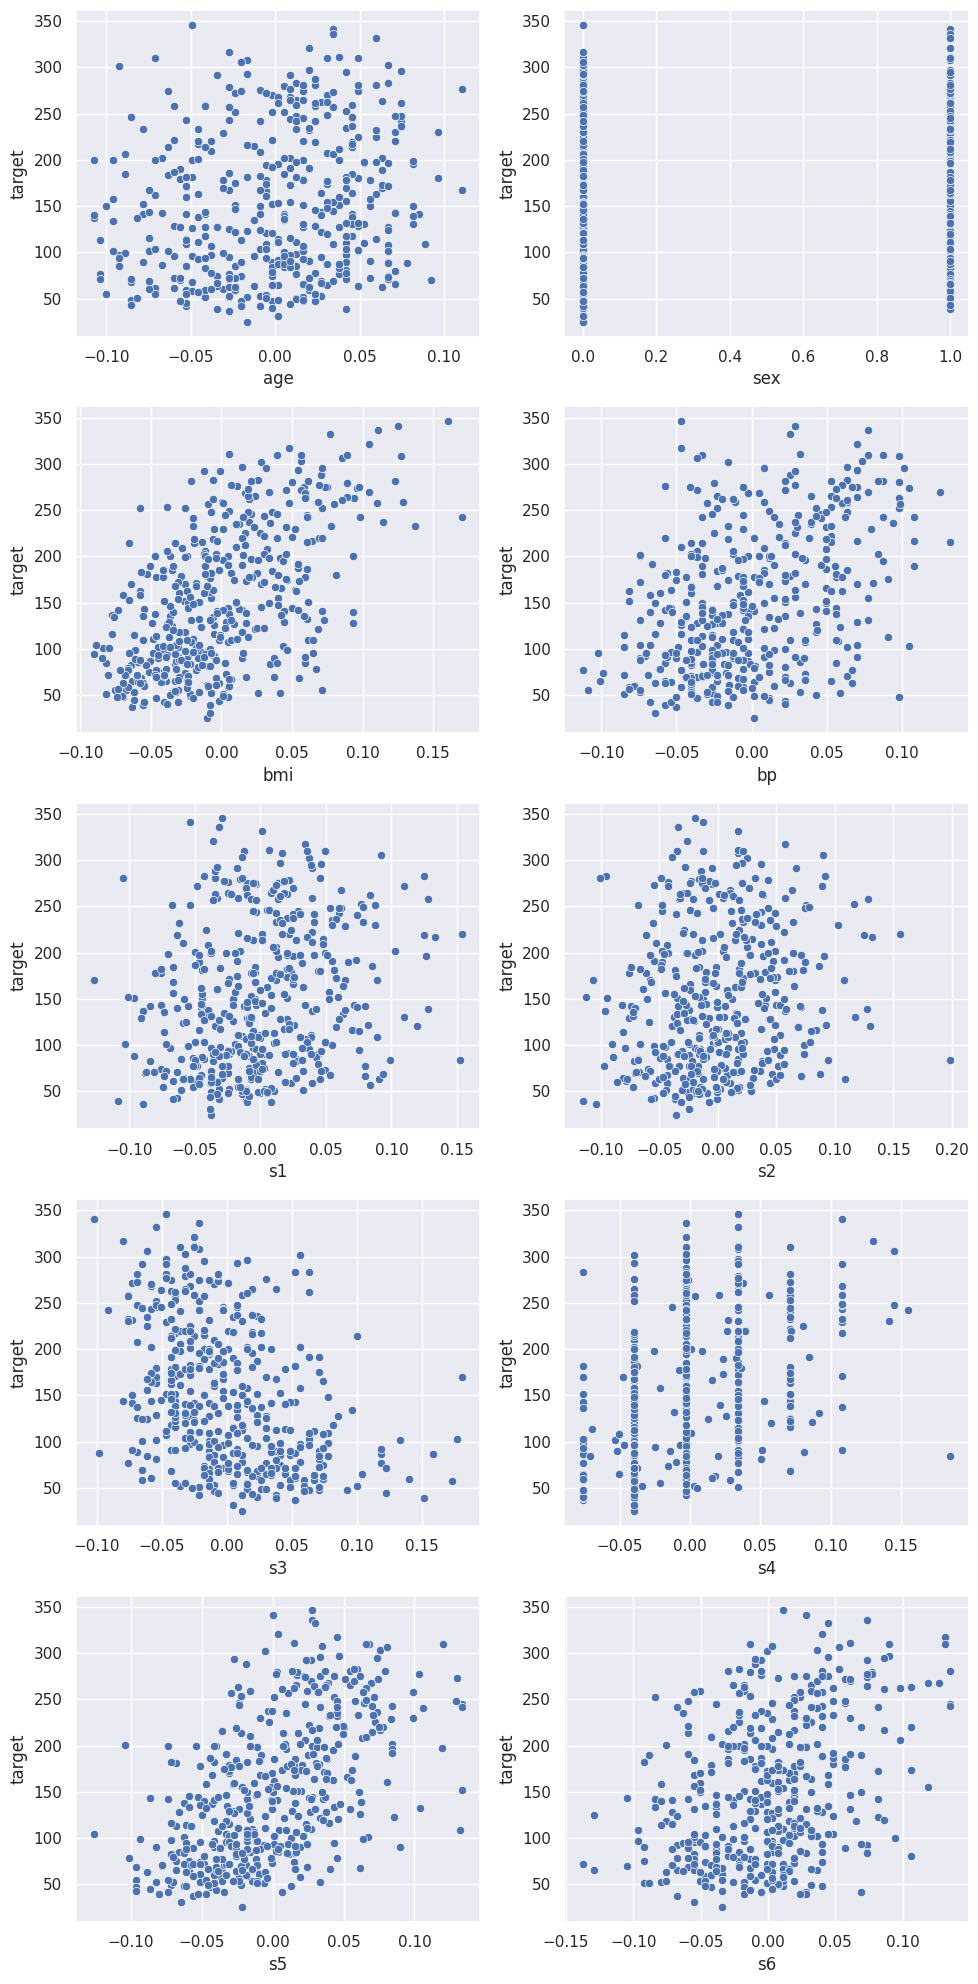

In [9]:
fig, ax = plt.subplots(5, 2, figsize=(10, 20))
fig.subplots_adjust(hspace=1, wspace=1)

indx = 0

for col in X.columns.drop('const'):
    row = indx // 2  # Índice da linha (dividindo indx por 2)
    col_pos = indx % 2  # Índice da coluna (0 ou 1)
    
    # Plotando no subplot correto
    sns.scatterplot(x=X[col], y=y, ax=ax[row, col_pos])
    
    # 
    ax[row, col_pos].set_xlabel(col)
    ax[row, col_pos].set_ylabel('target')
    
    indx += 1
plt.tight_layout()
plt.show()

Look in the graph, the variables `bmi`, `bp`, `s3`, `s4` and `s5` possibly exhibit a linear relationship with the response variable.

We can add or create variables that appear to be more useful and remove variables that do not appear to be useful. This is called **feature selection**, which we will cover soon.

### 5.3.2 - Normality of the residuals

To check the normality of the residuals, we can look at histograms and Q-Q plots.

In [10]:
residuals = model_fitted.resid

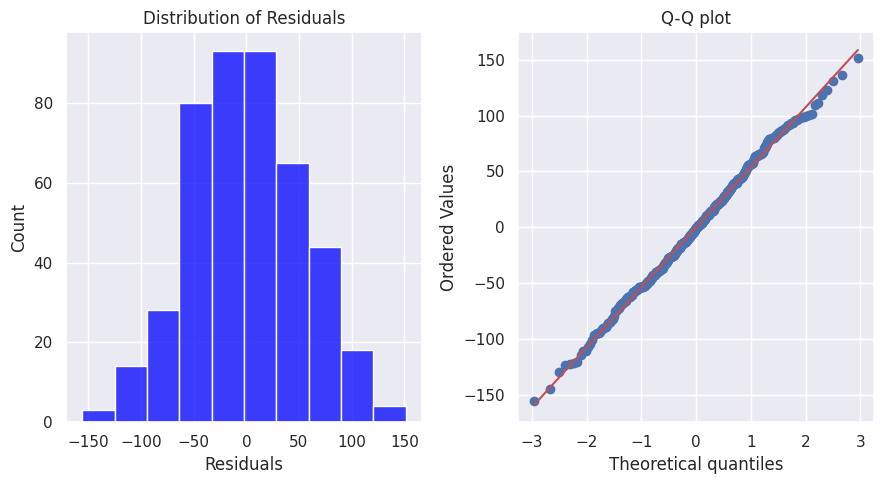

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(9,5))

sns.histplot(residuals, bins=10, ax=axes[0], color="blue" )
axes[0].set_xlabel("Residuals")
axes[0].set_title("Distribution of Residuals")

stats.probplot(residuals, dist='norm', plot=axes[1] )
axes[1].set_title("Q-Q plot")

plt.tight_layout()
plt.show()

Based in the histogram and Q-Q plot, we can see that the residuals are normally distributed.

### 5.3.3 - Homoscedasticity of the residuals


We expect that the residuals should exhibit homoscedasticity, to see this, we plot the scatter plot of the residuals against the fitted values.

In [12]:
fitted_values = model_fitted.fittedvalues

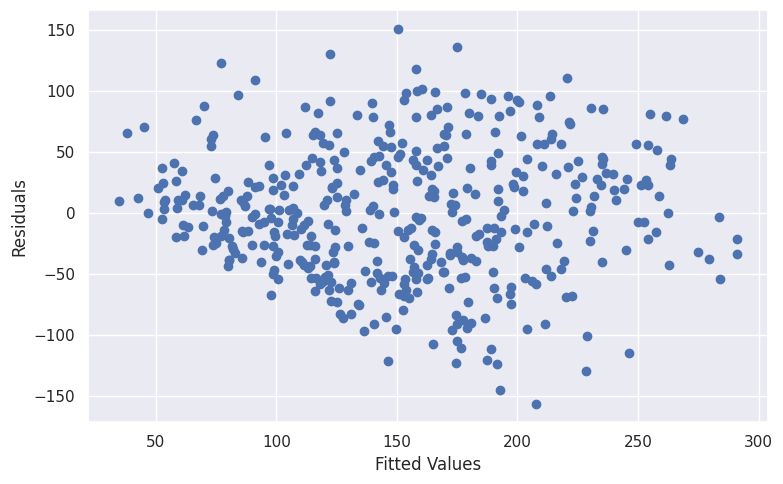

In [13]:
fig = plt.figure(figsize=(8,5))

plt.scatter(fitted_values, residuals)

plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()

There does not appear to be a clear pattern of changing variance or a significant outlier that would violate the assumption of homoscedasticity. If there had been a pattern, that would have been a sing that one or more of the variables may need to be transformed, or a sing of a non-linear relationship between the response and the exploratory variables.

### 5.3.4 - Independence of samples

For our case we cannot make a certain determination on whether the samples are independent without knowing the sampling methodology. Since we do not know the sampling strategy for this dataset, we will assume this assumption is met and proceed with the model.

### 5.3.5 - Multicollinearity

We discuss that the new assumptions for MLR is the Multicollinearity need to be little or no multicollinearity in the explanatory variables. We define multicollinearity as when two or more variables are strongly linearly correlated. To detected we commonly use the **variance inflation factor (VIF)** to detect multicollinearity. 

The VIF is a measurement of how much the coefficient of an explanatory variable is influenced by other explanatory variables and can be describe by equation:
$$ VIF_i = \frac{1}{1-R^2_i}$$

Where, $R^2$ is the coefficient of determination for regression model $X_i$.
. A lower VIF is better where the minimum value is 1, which means there is no correlation. We generally consider a VIF of 5 or more to be too high. When we have a variable with high VIF we remove the variable with the highest VIF until the VIF values for each variable are below 5. 

For due that, we need to use the `variance_inflation_factor()` from `statsmodels.stats.outliers_influence`

In [14]:
X.shape[1]

11

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['variable'] = X.columns
vif["vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.head(11)

,variable,vif
0,const,2.125790
1,age,1.217307
2,sex,1.278071
3,bmi,1.509437
4,bp,1.459428
5,s1,59.202510
6,s2,39.193370
7,s3,15.402156
8,s4,8.890986
9,s5,10.075967


Look in the dataframe, we can see that the variable `S1` has the highest VIF value, so we start to remove this variable and repeat the calculation.

In [16]:
vif = pd.DataFrame()
vif['variable'] = X.columns.drop('s1')
vif["vif"] = [variance_inflation_factor(X.drop('s1', axis=1).values, i) for i in range(len(vif['variable']))]
vif.head(10)


,variable,vif
0,const,2.123128
1,age,1.216892
2,sex,1.275049
3,bmi,1.502320
4,bp,1.457413
5,s2,2.926535
6,s3,3.736890
7,s4,7.818670
8,s5,2.172865
9,s6,1.484410


Now we can notice that the `s4` has the highest VIF value, so we remove this variable and repeat the calculation again.

In [17]:
vif = pd.DataFrame()
vif['variable'] = X.columns.drop(['s1','s4'])
vif["vif"] = [variance_inflation_factor(X.drop(['s1','s4'], axis=1).values, i) for i in range(len(vif['variable']))]
vif.head(10)


,variable,vif
0,const,2.117982
1,age,1.216284
2,sex,1.269207
3,bmi,1.498559
4,bp,1.447358
5,s2,1.180838
6,s3,1.473827
7,s5,1.641090
8,s6,1.476913


Now we have all variables with less than 5 VIF value indicating that there is a low correlation between the remaining variables. 
Let's remove this variables from our data and after we can proceeding with the model.

In [18]:
X_new = X.drop(['s1','s4'], axis=1)
X_new.head(10)

,const,age,sex,bmi,bp,s2,s3,s5,s6
0,1.0,0.038076,1,0.061696,0.021872,-0.034821,-0.043401,0.019907,-0.017646
1,1.0,-0.001882,0,-0.051474,-0.026328,-0.019163,0.074412,-0.068332,-0.092204
2,1.0,0.085299,1,0.044451,-0.005670,-0.034194,-0.032356,0.002861,-0.025930
3,1.0,-0.089063,0,-0.011595,-0.036656,0.024991,-0.036038,0.022688,-0.009362
4,1.0,0.005383,0,-0.036385,0.021872,0.015596,0.008142,-0.031988,-0.046641
5,1.0,-0.092695,0,-0.040696,-0.019442,-0.079288,0.041277,-0.041176,-0.096346
6,1.0,-0.045472,1,-0.047163,-0.015999,-0.024800,0.000779,-0.062917,-0.038357
7,1.0,0.063504,1,-0.001895,0.066629,0.108914,0.022869,-0.035816,0.003064
8,1.0,0.041708,1,0.061696,-0.040099,0.006202,-0.028674,-0.014960,0.011349
9,1.0,-0.070900,0,0.039062,-0.033213,-0.034508,-0.024993,0.067737,-0.013504


### 5.3.6 - Fit the model and Interpreting the results

Fitting the model and printing the summary we get the following results which are divided in the following sections:

- The top section contains high-level statistic about the model;
- The middle section contains information about the model coefficients;
- The bottom section contains diagnostic tests about the data and the residuals

In [19]:
model_fitted_new = sm.OLS(y, X_new).fit()
print(model_fitted_new.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     57.12
Date:                Thu, 27 Mar 2025   Prob (F-statistic):           4.35e-63
Time:                        16:56:30   Log-Likelihood:                -2387.9
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     433   BIC:                             4831.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        162.5006      3.757     43.257      0.0

1. **High-level statistic about the model**

In the top section of the fir results, we have model-level information. In the left side contains information about the model such as the **degrees of freedom (df)** and the number of observations

2. **Model coefficient details**

In the middle section contains details about the model coefficient, the $\beta$ terms in the equations. Two important columns is:

- `coef`: is the model coefficient estimated for the model equation, the value of $\beta$;
- `P>|t|`: Is the p-value for a significance test for the coefficient.

Remembering that the null hypothesis for this test is that **the value of the $\beta$ parameter is equal to zero**. For our case, we reject the null hypothesis for `const`, `sex`, `bmi`, `bp`, `s3` and `s5`. And we fail to reject the nul hypothesis for `age`, `s2` and `s6`.

For variables that we reject the null hypothesis, we can provide an interpretation, but for variables that we fail to reject we will not able to provide an interpretation because their coefficient values might be zero. If the coefficient value is zero, then the variable makes no contribution to the model. 

**Interpreting continuous variable coefficients**

For the continuous variables, such as `BMI`, we find its coefficient is approximately 526, we would say "A unit increase in `bmi` would be associated with a 526 increase in the mean of the diabetes measurement with all other variables held constants".

**Interpreting categorical variable coefficients**

In categorical variables, such as `sex`, the values of the categorical are dummy-encoded, and can only take two values:zero or one. Also recall that one level was chosen to be the reference level. In this case, `sex` level 0 is the reference level and we can compare this reference to `sex` level 1. When we use the reference level, the coefficient will not affect the output of the model. Similar to the continuous variable, the categorical-level change is associated with a change in the mean of the dependent variable by the size of the coefficient with all other variables held constant.\n
For example, the coefficient in `sex` is approximately -22, we would say, "The level of `sex`is associated with a decrease of 22 in the mean of the diabetes measurement compared to the reference level with all other variables held constant."

3. **Diagnostic test**

In the bottom section of the fit results contains diagnostic statistic for the data and residuals. Looking in the list we have:

- **The Durbin-Watson test:** Which is a test for serial correlation, and a result around 2 is not indicative of serial correlation. 
- **The Skew and Kurtosis:** Which give us the measurements of the shape of the distribution of the residuals. These results indicate almost no skew, but possibly some kurtosis, which indicate a small deviations from the normal distribution.

## 5.4 - Feature Selection

In the previous section we fit the model and many factors can influence the success or failure of a model, such as sampling, data quality, feature creation, and model selection. However, ont of those critical factor is **feature selection**. 

Feature selection is simply the process of choosing or systematically determining the best features for a model from an existing set of features. We have done some simple feature selection already, like remove the high VIFs. We will go through two methods:

- Statistical methods for feature selection;
- Performance-based methods for feature selection.

### 5.4.1 - Statistical methods for feature selection

In this section we cover two statistical methods for feature selection, one is correlation and statistical significance.

#### 5.4.1.1 - Correlation

We already discussed correlation in this chapter and in previous chapters. Recall that correlation is a description of the relationship between two variables. We have positive and negative correlation. In terms of feature selection, we want to *remove features that are uncorrelated with the response variable*. 

Let's take the original dataset and look for the heatmap correlation again:

In [20]:
X.columns

Index(['const', 'age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')

In [21]:
all_data = pd.DataFrame(data['data'], columns=['age', 'sex','bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'])
all_data['target'] = data['target']
all_data.head(10)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
5,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041176,-0.096346,97.0
6,-0.045472,0.050680,-0.047163,-0.015999,-0.040096,-0.024800,0.000779,-0.039493,-0.062917,-0.038357,138.0
7,0.063504,0.050680,-0.001895,0.066629,0.090620,0.108914,0.022869,0.017703,-0.035816,0.003064,63.0
8,0.041708,0.050680,0.061696,-0.040099,-0.013953,0.006202,-0.028674,-0.002592,-0.014960,0.011349,110.0
9,-0.070900,-0.044642,0.039062,-0.033213,-0.012577,-0.034508,-0.024993,-0.002592,0.067737,-0.013504,310.0


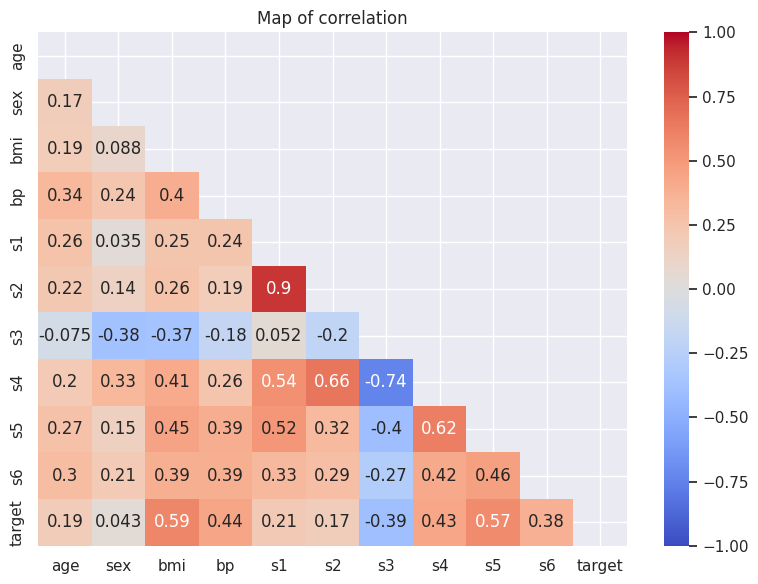

In [22]:
# Map of correlations

fig, ax = plt.subplots(figsize=(8, 6))
mask = np.triu(np.ones_like(all_data.corr(), dtype=bool))

heatmap = sns.heatmap(all_data.corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm', mask=mask, ax=ax)
ax.set_title("Map of correlation")
plt.tight_layout()
plt.show()

In [23]:
all_data.corr()[['target']].sort_values('target', ascending=False)

,target
target,1.000000
bmi,0.586450
s5,0.565883
bp,0.441482
s4,0.430453
s6,0.382483
s1,0.212022
age,0.187889
s2,0.174054
sex,0.043062


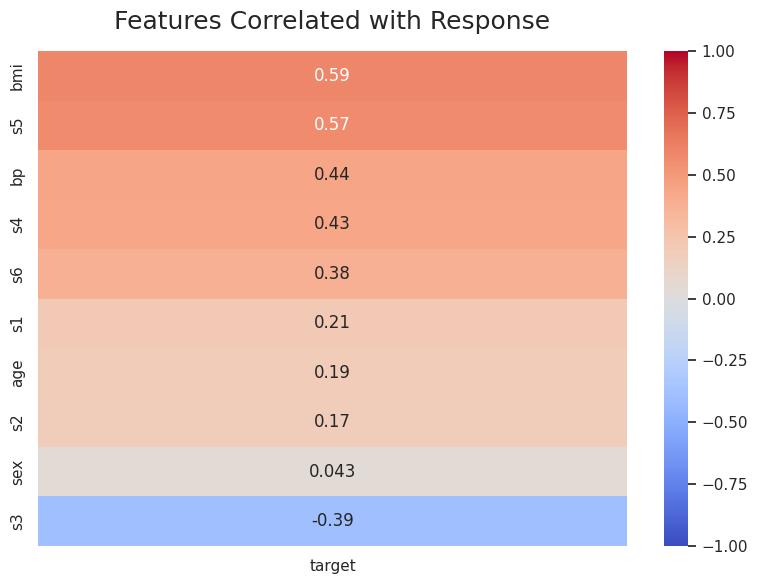

In [24]:
# Feature correlation with response variable
fig, ax = plt.subplots(figsize=(8, 6))

heatmap = sns.heatmap(all_data.corr()[['target']].drop('target').sort_values('target', ascending=False), vmin=-1, vmax=1, annot=True, cmap='coolwarm', ax= ax)
ax.set_title("Features Correlated with Response", fontdict={'fontsize':18}, pad=16)

plt.tight_layout()
plt.show()


When evaluating features based on correlation, we are most interested in features with a high *absolute* correlation. For example, in the figure before, we have:

- `bmi` and `s5` exhibit a strong correlation with the response variable;
- `bp`, `s4`, `s6` and `s3` exhibit moderate correlation with the response variable;
- `s1`, `age`, and `s2` exhibit a weak correlation with the response variable;

While`sex` may appear to show no correlation with the response variable, Pearson's correlation coefficient cannot be used with categorical features. From this results, we can see that, at least, `bmi`, `s5` and `bp` are likely among the best features in this dataset for predicting the response.



### 5.4.1.2 - Statistical significance


In this process we can select features using the statistical significance of the feature in the context of a model. We have three forms:
- Forward selection;
- Backward selection;
- Stepwise selection.

This methods were used in the past. However, in recent year, performance-based methods have become more widely used.

### 5.4.2 - Performance-based methods for feature selection

In the previous method mentioned the primary issue with the statistical feature selection is that they tend to create **overfit** models. An overfit model is a model that fits the given data exactly and fails to generalize to new data. 

Performance-based methods overcome overfitting using a method called **cross-validation**. In cross-validation, we have two datasets: a **training dataset** used to fit the model and a **test dataset** for evaluating the model. We can build models from multiple sets of features, fit all those potential models on the training set, and finally rank them based on the performance of the models on the testing set with a given metric.

#### 5.4.2.1 - Comparing models

Before we get into feature selection methods, we need first discuss how to compare models. For this, we have two metrics:

- Mean Squared Error (MSE);
- Absolute Percentage error (MAPE).

- **MSE** is given by the following formula, where $N$ is the number of samples, $y$ is the response variable and $\hat{y}$ is the predicted value of the response variable.

$$MSE = \frac{1}{N}\sum_{i=1}^{N}(y_i-\hat{y}_i)^2$$

We have too the **Root mean squared error (RMSE)** which is $RMSE = \sqrt{MSE}$, used when it is desirable for the metric to have the same units as the response variable.

- **MAPE** is given by the following formular, where $N$ is the number of samples, $y$ is the response variable, and $\hat{y}$ is the predicted value of the response variable.
$$MAPE = \frac{1}{N}\sum_{i=1}^{N}\frac{|y_i-\hat{y}_i|}{y_i}$$

This equation is like the MSE, but instead of taking the mean of the square error, we take the mean of the percent error. For both metrics the lower the values of theses metrics the better.

#### 5.4.2.2 - Recursive feature elimination

**Recursive feature elimination (RFE)** is a method for selecting an optimal number of features in a model using a metric. We start with all features in the model, then removes  features with the least influence on the model. At each step, cross-validation is performed. When RFE is completed, we will be able to see the cross-validation performance of the model over the various sets of features.

Let's putting this in practical..

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFECV

# Definition of MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) *100

# transform the score compatible with cross_val_score
mape_scorer = make_scorer(mape, greater_is_better=False)


linear_model = LinearRegression()
linear_model.fit(X, y)

rfecv = RFECV(estimator=linear_model, 
              step=1, 
              cv=2, 
              scoring = mape_scorer,
              min_features_to_select = 1)

rfecv.fit(X,y)

RFECV(cv=2, estimator=LinearRegression(),
      scoring=make_scorer(mape, greater_is_better=False, response_method='predict'))

In [26]:
# The coefficients for the model
linear_model.coef_

array([   0.        ,  -10.0098663 ,  -22.85964809,  519.84592005,
        324.3846455 , -792.17563855,  476.73902101,  101.04326794,
        177.06323767,  751.27369956,   67.62669218])

In [27]:
# The coefficient to the intercept
linear_model.intercept_

np.float64(162.83924695640994)

In [28]:
print("Optimal number of features: %d" % rfecv.n_features_)

Optimal number of features: 10


We can plot the results

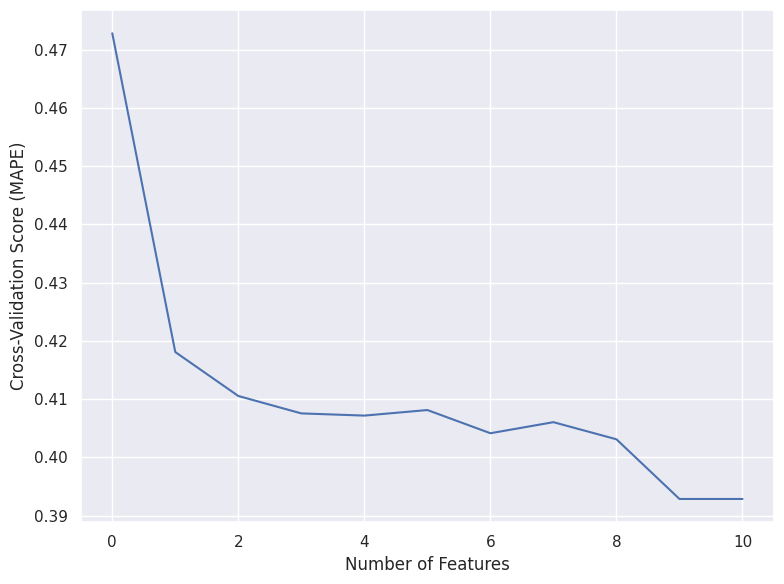

In [29]:
fig = plt.figure(figsize=(8, 6))

plt.plot(range(len(rfecv.cv_results_['mean_test_score'])),
         # need to negative sing here due to scorer behavior
         -rfecv.cv_results_['mean_test_score']/100) 

plt.xlabel("Number of Features")
plt.ylabel("Cross-Validation Score (MAPE)")
plt.tight_layout()
plt.show()

After the analysis we can see that including all features produces the best-performing model but including all 10 features only provides a small increase over the performe of just five features.f

## Shrinkage methods

Shrinkage methods are a family of regularization techniques used primarily in statistic modeling and machine learning to improve the prediction performance of models by reducing overfitting. The idea is to "**shrink**" or "**penalize**" the regression coefficients or model parameters towards zero or some other target value.

In simples terms, shrinkage methods restrict or reduce the magnitude of model coefficients to make the model simpler and less prone to fitting noise or irrelevant patterns in the data. This helps prevent overfitting, which occurs when a model fits the training data too closely, capturing random fluctuations rather than generalizable trends.

Let's see some methods.

### 5.5.1 - Ridge Regression 

First let's recall the formulation for the **residual sum of squared errors (RSS)** for multiple linear regression:

$$RSS = \sum_{i=1}^{n}(y_i-\hat{\beta}_0 - \sum_{j=1}^{p} \hat{\beta}_j x_{ij})^2$$

where $n$ is the number of samples and $p$ is the number of parameter. Ridge regression adds a scalar, $\lambda$, called a **tuning parameter** - which must be greater than or equal to 0 - that gets multiplied by the model parameter coefficient estimates, $\hat{\beta}^2_j$, to create a **shrinkage penalty**. 